## Assignment 1.b

## Model fitting 

### importing the required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from collections import Counter
#!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neural_network import MLPClassifier

import os
import tensorflow as tf
from __future__ import print_function
from tensorflow import keras

np.random.seed(1)

In [3]:
import os
print(os.getcwd())

C:\Users\Nithin Yadav\Downloads


## Loading the preprocessed data 

In [4]:
train_df=pd.read_csv("default_train_df.csv")
test_df=pd.read_csv("default_test_df.csv")
X_train=pd.read_csv("default_train_X.csv")
X_test=pd.read_csv("default_test_X.csv")
y_train=pd.read_csv("default_train_y.csv")
y_test=pd.read_csv("default_test_y.csv")

In [5]:
y_train.value_counts()

DEFAULT PAYMENT NEXT MONTH
0                             16364
1                              4636
dtype: int64

*** There is a huge imbalance in the trained data so we need to perform a data imbalance techniqu in order to encounter the biased results ***

## Data imbalancing 

In [6]:
undersample = RandomUnderSampler(sampling_strategy='majority')

X_train, y_train = undersample.fit_resample(X_train, y_train)

print(Counter(y_train))

Counter({'DEFAULT PAYMENT NEXT MONTH': 1})


In [7]:
y_train.value_counts()

DEFAULT PAYMENT NEXT MONTH
0                             4636
1                             4636
dtype: int64

## Standardizing the variables

Here we will be standardizing the variables of each attribute in order to reduce the differences among them so that we will be able to predict the scores accurately

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)

# Transform the predictors of training and test sets
X_train = scaler.transform(X_train) 
 

X_test = scaler.transform(X_test)


In [9]:
X_train 

array([[-0.1594649 ,  1.59086926,  0.83370498, ...,  1.48177835,
        -0.22219406, -0.22989422],
       [ 0.87887396, -0.50438208,  0.83370498, ..., -0.10248862,
         0.01905733, -0.22452629],
       [-0.24172336, -0.42379549, -1.19946507, ..., -0.29645833,
        -0.07275223, -0.28920017],
       ...,
       [ 0.50824613,  0.22089723,  0.83370498, ..., -0.29645833,
        -0.28920834, -0.28920017],
       [-1.40542505, -0.42379549, -1.19946507, ..., -0.29645833,
        -0.24424176, -0.245804  ],
       [ 0.25914704,  0.14031064,  0.83370498, ..., -0.22405455,
        -0.28920834,  2.08297309]])

### What is the best evaluating matrix????

Our aim for this analysis is to predict accurately the default payments of a transaction. So we will be dealing with both the True Positives and False Negitives of the problem because, True positives(TP) gives number of times the model correctly predicts a default payment whereas False Negitives(FN) gives the number of times the model incorrectly predicts a non-default payment when the actual payment is a default. False negitives are also as important as True Negitives in order to define this model s accurate one.

Recall is a predictive metric that deals with both true positives and false negatives. The proportion of true positives among all actual positive observations is measured by recall. It indicates how well the model can identify positive cases.

Formula :
Recall = True Positives / (True Positives + False Negatives)

## Modelling the data with various modelling techniques

In [10]:
performance = pd.DataFrame({"model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []})

### Decision Trees
### Using Random search and grid search

In [10]:
score_measure = "recall"
kfolds = 3

param_grid = {
    'min_samples_split': np.arange(1,50),  
    'min_samples_leaf': np.arange(1,50),
    'min_impurity_decrease': np.arange(0.001, 0.005),
    'max_leaf_nodes': np.arange(5, 100), 
    'max_depth': np.arange(1,25), 
    'criterion': ['entropy', 'gini'],
}

dtree = DecisionTreeClassifier()
rand_search = RandomizedSearchCV(estimator = dtree, param_distributions=param_grid, cv=kfolds, n_iter=100,
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

best_DTree = rand_search.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
The best recall score is 0.6048203178749908
... with parameters: {'min_samples_split': 45, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 89, 'max_depth': 23, 'criterion': 'gini'}


In [11]:
score_measure = "recall"
kfolds = 5
min_samples_split = rand_search.best_params_['min_samples_split']
min_samples_leaf = rand_search.best_params_['min_samples_leaf']
min_impurity_decrease = rand_search.best_params_['min_impurity_decrease']
max_leaf_nodes = rand_search.best_params_['max_leaf_nodes']
max_depth = rand_search.best_params_['max_depth']
criterion = rand_search.best_params_['criterion']
#Using the best parameters from the Random Search to use as range for the parameters to do the grid search
param_grid = {
    'min_samples_split': np.arange(min_samples_split-2,min_samples_split+2),  
    'min_samples_leaf': np.arange(min_samples_leaf-2,min_samples_leaf+2),
    'min_impurity_decrease': np.arange(min_impurity_decrease-0.0001, min_impurity_decrease+0.0001, 0.00005),
    'max_leaf_nodes': np.arange(max_leaf_nodes-2,max_leaf_nodes+2), 
    'max_depth': np.arange(max_depth-2,max_depth+2), 
    'criterion': [criterion]
}

dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

best_DTree = grid_search.best_estimator_

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits
The best recall score is 0.5759336755570434
... with parameters: {'criterion': 'gini', 'max_depth': 21, 'max_leaf_nodes': 87, 'min_impurity_decrease': 0.00095, 'min_samples_leaf': 3, 'min_samples_split': 43}


In [12]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
print(f"Accuracy={(TP+TN)/(TP+TN+FP+FN):.7f} Precision={TP/(TP+FP):.7f} Recall={TP/(TP+FN):.7f} F1={2*TP/(2*TP+FP+FN):.7f}")
Recall_Dtree= {TP/(TP+FN)}

Accuracy=0.7717778 Precision=0.4876147 Recall=0.5315000 F1=0.5086124


In [13]:
performance = pd.concat([performance, pd.DataFrame({'model':"Decision Tree", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

In [14]:
performance

,model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.771778,0.487615,0.5315,0.508612


###  Logistic Regression
### using Random search and grid search

In [15]:
score_measure = "recall"
kfolds = 3

param_grid = {'C':[0.01,0.1,1,2,10], # C is the regulization strength
               'penalty':['l1', 'l2','elasticnet','none'],
              'solver':['saga','liblinear'],
              'max_iter': np.arange(250,500)
                  
}

log_reg = LogisticRegression()
rand_search = RandomizedSearchCV(estimator =log_reg, param_distributions=param_grid, cv=kfolds, n_iter=100,
                           scoring=score_measure, verbose=1, n_jobs=-1  # n_jobs=-1 will utilize all available CPUs 
                                )

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

best_log_reg = rand_search.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\Nithin Yadav\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
132 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Nithin Yadav\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nithin Yadav\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "C:\Users\Nithin Yadav\anaconda3\envs\tf\lib\site-packages\sklearn

The best recall score is 0.628124358926052
... with parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 390, 'C': 0.01}


In [16]:
score_measure = "recall"
kfolds = 3
best_penality = rand_search.best_params_['penalty']
best_solver = rand_search.best_params_['solver']
min_regulization_strength=rand_search.best_params_['C']
min_iter = rand_search.best_params_['max_iter']

#Using the best parameters from the Random Search to use as range for the parameters to do the grid search
param_grid = {
    
    'C':np.arange(min_regulization_strength,min_regulization_strength+0.5), 
               'penalty':[best_penality],
              'solver':[best_solver],
              'max_iter': np.arange(min_iter-300,min_iter+300)
}

log_reg =  LogisticRegression()
grid_search = GridSearchCV(estimator = log_reg, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,error_score='raise' # n_jobs=-1 will utilize all available CPUs 
                )

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

best_log_reg = grid_search.best_estimator_

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


C:\Users\Nithin Yadav\anaconda3\envs\tf\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The best recall score is 0.628124358926052
... with parameters: {'C': 0.01, 'max_iter': 90, 'penalty': 'l2', 'solver': 'saga'}


In [17]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
print(f"Accuracy={(TP+TN)/(TP+TN+FP+FN):.7f} Precision={TP/(TP+FP):.7f} Recall={TP/(TP+FN):.7f} F1={2*TP/(2*TP+FP+FN):.7f}")
Recall_logistic= {TP/(TP+FN)}

Accuracy=0.7022222 Precision=0.3914432 Recall=0.6130000 F1=0.4777864


In [18]:
performance = pd.concat([performance, pd.DataFrame({'model':"logistic regression using random search & grid search", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

In [19]:
performance

,model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.771778,0.487615,0.5315,0.508612
0,logistic regression using random search & grid...,0.702222,0.391443,0.6130,0.477786


### SVM using random search and grid search

In [ ]:
score_measure = "recall"
kfolds = 3

param_grid = {'C':np.arange(0.1,50,10), 
               'kernel':['linear', 'rbf','poly'],
              'gamma':['scale','auto'],
              'degree':np.arange(1,10), 
              'coef0':np.arange(1,10)
}

svc = SVC()
rand_search = RandomizedSearchCV(estimator =svc, param_distributions=param_grid, cv=kfolds, n_iter=100,
                           scoring=score_measure, verbose=1, n_jobs=-1  # n_jobs=-1 will utilize all available CPUs 
                                )

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

bestsvc = rand_search.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
score_measure = "recall"
kfolds = 3
best_kernel = rand_search.best_params_['kernel']
best_gamma = rand_search.best_params_['gamma']
min_regulization=rand_search.best_params_['C']
best_degree = rand_search.best_params_['degree']
best_coef0=rand_search.best_params_['coef0']

#Using the best parameters from the Random Search to use as range for the parameters to do the grid search
param_grid = {
    
    'C':np.arange(min_regulization-3,min_regulization+3), 
               'kernel':[best_kernel],
              'gamma':[best_gamma],
              'degree': np.arange(best_degree-1,best_degree+1),
            'coef0': np.arange(best_coef0-3,best_coef0+3)
}

svm_grid =  SVC()
grid_search = GridSearchCV(estimator = svm_grid, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1 # n_jobs=-1 will utilize all available CPUs 
                )

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

best_svm = grid_search.best_estimator_

In [ ]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
print(f"Accuracy={(TP+TN)/(TP+TN+FP+FN):.7f} Precision={TP/(TP+FP):.7f} Recall={TP/(TP+FN):.7f} F1={2*TP/(2*TP+FP+FN):.7f}")
F1_svm=2*TP/(2*TP+FP+FN)

In [ ]:
performance = pd.concat([performance, pd.DataFrame({'model':"svm ", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

#### We can observe that the recall score of decision tree and logistic regression using random search and grid search is 0.60 and 0.62 respectively which is almost equal. Comming to Support Vector Machines we are unable to get the result because of (incompatability of the system). So in this business problem we are mostly focussed on true positives(TP)(gives number of times the model correctly predicts a default payment) and False negatives(FN)(gives the number of times the model incorrectly predicts a non-default payment when the actual payment is a default). So when compared the best AI model developed to detect the default payments of both TP and FN is logisitic regression model. This model can detect the solution with less FN and more TP

## MLP Classifier using SKlearn


In [20]:
%%time

ann = MLPClassifier(hidden_layer_sizes=(60,50,40), solver='adam', max_iter=200)
_ = ann.fit(X_train,np.ravel( y_train))

CPU times: total: 40 s
Wall time: 13.4 s


C:\Users\Nithin Yadav\anaconda3\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
%%time
y_pred = ann.predict(X_test)

CPU times: total: 31.2 ms
Wall time: 16.5 ms


In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.74      0.79      7000
           1       0.38      0.55      0.45      2000

    accuracy                           0.70      9000
   macro avg       0.62      0.65      0.62      9000
weighted avg       0.75      0.70      0.72      9000



In [23]:
%%time

score_measure = "recall"
kfolds = 3

param_grid = {
    'hidden_layer_sizes': [ (64,), (128,),(128,64), (64,128), (64,128,196), (196,128,64)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0, .001, .005, .01, .05],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1, 0.2, 0.5],
    'early_stopping':[True],
    'max_iter': [1000]
}

ann = MLPClassifier()
grid_search = RandomizedSearchCV(estimator = ann, param_distributions=param_grid, cv=kfolds, n_iter=100,
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

bestRecallTree = grid_search.best_estimator_

print(grid_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\Nithin Yadav\anaconda3\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'solver': 'adam', 'max_iter': 1000, 'learning_rate_init': 0.5, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (128, 64), 'early_stopping': True, 'alpha': 0.001, 'activation': 'relu'}
CPU times: total: 3.53 s
Wall time: 4min 16s


In [24]:
%%time
y_pred = bestRecallTree.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      7000
           1       0.00      0.00      0.00      2000

    accuracy                           0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.60      0.78      0.68      9000

CPU times: total: 78.1 ms
Wall time: 49.8 ms


C:\Users\Nithin Yadav\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nithin Yadav\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nithin Yadav\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## With GridSearchCV

In [25]:
%%time

score_measure = "recall"
kfolds = 3

param_grid = {
    'hidden_layer_sizes': [ (64,), (128,),(128,64)],
    'activation': ['logistic', 'relu'],
    'solver': ['sgd'],
    'alpha': [0,.5 ],
    'learning_rate': ['adaptive', 'invscaling'],
    'learning_rate_init': [0.1,0.2,0.5],
    'max_iter': [1000]
}

ann = MLPClassifier()
grid_search = GridSearchCV(estimator = ann, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

bestRecallTree = grid_search.best_estimator_

print(grid_search.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\Nithin Yadav\anaconda3\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'activation': 'relu', 'alpha': 0, 'hidden_layer_sizes': (64,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.2, 'max_iter': 1000, 'solver': 'sgd'}
CPU times: total: 27.9 s
Wall time: 7min 54s


In [26]:
%%time
y_pred = bestRecallTree.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.70      0.78      7000
           1       0.38      0.64      0.47      2000

    accuracy                           0.69      9000
   macro avg       0.62      0.67      0.62      9000
weighted avg       0.76      0.69      0.71      9000

CPU times: total: 62.5 ms
Wall time: 32.1 ms


In [27]:
c_matrix = confusion_matrix(y_test, y_pred)
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
print(f"Accuracy={(TP+TN)/(TP+TN+FP+FN):.7f} Precision={TP/(TP+FP):.7f} Recall={TP/(TP+FN):.7f} F1={2*TP/(2*TP+FP+FN):.7f}")
F1_lr=2*TP/(2*TP+FP+FN)



Accuracy=0.6853333 Precision=0.3772137 Recall=0.6390000 F1=0.4743875


In [28]:
performance = pd.concat([performance, pd.DataFrame({'model':"neural network using random & grid search", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

In [29]:
performance

,model,Accuracy,Precision,Recall,F1
0,Decision Tree,0.771778,0.487615,0.5315,0.508612
0,logistic regression using random search & grid...,0.702222,0.391443,0.6130,0.477786
0,neural network using random & grid search,0.685333,0.377214,0.6390,0.474388


 #### We've used random and grid search to implement the SKlearn MLP classifier, and there are important parameters that go into determining the data's confusion matrix. We have provided the hidden layer size values as multiples of 4, as well as the number of data entries as multiples of 4. Max_iter is specified as 1000, which should be practical given the compatibility of the system. The best parameters from the above result were utilized to do grid search after performing random search in order to obtain the mlp classifier predictive model.

### Keras Sequential Search 

In [15]:
%%time

# If you don't have the following installed, from command line '!pip install scikeras'
from scikeras.wrappers import KerasClassifier
from keras.initializers import GlorotNormal

score_measure = "recall"
kfolds = 3

def build_clf(hidden_layer_sizes, dropout):
    ann = tf.keras.models.Sequential()
    ann.add(keras.layers.Input(shape=24)),
    for hidden_layer_size in hidden_layer_sizes:
        ann.add(keras.layers.Dense(hidden_layer_size, kernel_initializer= tf.keras.initializers.GlorotUniform(), 
                                     bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None), activation="relu"))
        ann.add(keras.layers.Dropout(dropout))
    ann.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    #the out is either 0 or 1 which is single numeric value, like a regression task so the tensor shape is (None,1)
    
    ann.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
    return ann

CPU times: total: 0 ns
Wall time: 0 ns


In [16]:
from scikeras.wrappers import KerasClassifier

keras_clf = KerasClassifier(
    model=build_clf,
    hidden_layer_sizes=64,
    dropout = 0.0
)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV

params = {
    'optimizer__learning_rate': [0.0005, 0.001, 0.005],
    'model__hidden_layer_sizes': [(70,),(90, ), (100,), (100, 90)],
    'model__dropout': [0, 0.1],
    'batch_size':[20, 60, 100],
    'epochs':[10, 50, 100],
    'optimizer':["adam",'sgd']
}
keras_clf.get_params().keys()


dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'hidden_layer_sizes', 'dropout', 'class_weight'])

In [18]:
rnd_search_cv = RandomizedSearchCV(estimator=keras_clf, param_distributions=params, scoring='f1', n_iter=50, cv=5)

import sys
sys.setrecursionlimit(10000) # note: the default is 3000 (python 3.9)

earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
callback = [earlystop]

_ = rnd_search_cv.fit(X_train, y_train, callbacks=callback, verbose=0)


31/31 [==============================] - 0s 2ms/step


In [19]:
rnd_search_cv.best_params_

{'optimizer__learning_rate': 0.005,
 'optimizer': 'adam',
 'model__hidden_layer_sizes': (90,),
 'model__dropout': 0,
 'epochs': 10,
 'batch_size': 20}

In [20]:
best_model = rnd_search_cv.best_estimator_

In [21]:
%%time

print(f"best score {best_model.score(X_test, y_test)}")
print(f"min loss {min(best_model.history_['loss'])}")

450/450 [==============================] - 1s 2ms/step
best score 0.7553333333333333
min loss 0.5560616254806519
CPU times: total: 4.53 s
Wall time: 1.26 s


In [22]:
best_model.history_

defaultdict(list,
            {'loss': [0.6037212014198303,
              0.5836703181266785,
              0.574445903301239,
              0.5693883299827576,
              0.5662752389907837,
              0.5630691051483154,
              0.5613280534744263,
              0.5591203570365906,
              0.5575400590896606,
              0.5560616254806519],
             'accuracy': [0.6761216521263123,
              0.6976919770240784,
              0.7068593502044678,
              0.7073985934257507,
              0.7160267233848572,
              0.7148403525352478,
              0.7148403525352478,
              0.7185073494911194,
              0.7190465927124023,
              0.7169973850250244]})

450/450 [==============================] - 1s 2ms/step


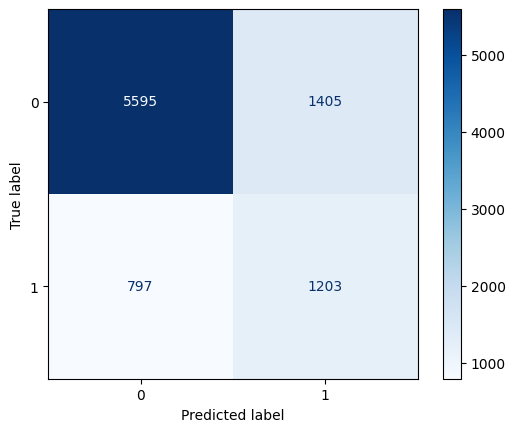

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, best_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, best_model.predict(X_test), digits=4))

450/450 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0     0.8753    0.7993    0.8356      7000
           1     0.4613    0.6015    0.5221      2000

    accuracy                         0.7553      9000
   macro avg     0.6683    0.7004    0.6789      9000
weighted avg     0.7833    0.7553    0.7659      9000



In [25]:
y_pred=best_model.predict(X_test)

450/450 [==============================] - 1s 1ms/step


In [26]:
%%time
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

450/450 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      7000
           1       0.46      0.60      0.52      2000

    accuracy                           0.76      9000
   macro avg       0.67      0.70      0.68      9000
weighted avg       0.78      0.76      0.77      9000

CPU times: total: 3.75 s
Wall time: 968 ms


In [27]:
c_matrix = confusion_matrix(y_test, y_pred)
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
print(f"Accuracy={(TP+TN)/(TP+TN+FP+FN):.7f} Precision={TP/(TP+FP):.7f} Recall={TP/(TP+FN):.7f} F1={2*TP/(2*TP+FP+FN):.7f}")
F1_lr=2*TP/(2*TP+FP+FN)



Accuracy=0.7553333 Precision=0.4612730 Recall=0.6015000 F1=0.5221354


In [28]:
performance = pd.concat([performance, pd.DataFrame({'model':"using keras", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

In [29]:
performance

,model,Accuracy,Precision,Recall,F1
0,using keras,0.755333,0.461273,0.6015,0.522135


## Conclusion

Models performed in this assignment :

    Decision Tree using random search and grid search     
    Logistic regression using random search and grid search
    SVM using random search and grid search
    SKlearn MLP classifier using random search and grid search
    Keras Sequential Search 
 

 Confusion Matrix Display:
    From the keras model we can interpret the confusion matrix details as number of TP are 1203, number of FN  are -5595. 
    as per the business problem here we will be concentrating on TP and FN. total of 1203 predictions are donw where the model       correctly predicts a default payment whereas the total of 5595 predictions were done where the  model incorrectly predicts a     non-default payment when the actual payment is a default. 

From all the predicted models we will be concentrating on the recall score of each model as it depends on both TP and FN. 
The recall scores obtained are 

Note : SVM is The model is taking a lot longer than anticipated to run, tried a number of tests and experiments to try to figure out what's causing this problem, but I've been unsuccessful so far
.
decision tree :  0.53
Logistic regression : 0.61
MLP classifier : 0.63
Keras sequencial search : 0.60

Here by we can conclude that the best predictive model is MLP classifier model.
Comparing the MLP classifier with the past models used such as decision tree model , decision tree models are more prone to over fitting but incase of MLP classifier we can overcome the issue by regularization techniques. 
MLP classifier can model more complex linear relationships when compared to the past models (decision trees and logistic regression)


As per my research while comparing both mlp classifier and logisitic regression we can observe that mlp classfier can peform much more better when dealing with complex relationships or high dimensional data. however, when dealing with simplier data logisitic is the good model to be used.